# Dimensionality Reduction
During the analysis phase, you might find that you have too many variables, or that you have a number of variables that aren't helpful in training a classifier.  In these circumstances, it is useful to determine which variables contain important information to identify classes or predict values, and separate them from the rest.  In the following examples, we will focus on classification problems, but these lessons apply to regression algorithms as well.

## Covariance Matrix
As a starting point, it is useful to use either a covariance matrix or the *corr()* function to determine which variables are correlated.  As a reminder, the Pandas *corr* function will return a value from -1 to 1, with 0 indicating the 2 variables are not related at all, and -1 and 1 indicate they are perfectly correlated.  

You can find additional information on the *corr()* function here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

# Workshop Functions
import sys
sys.path.append('..')
from WKDSS320_functions import * 

Next let's load a standard dataset called *Iris* which contains information about 3 types of Iris plants.  It is a standard training dataset.  More information on this dataset is here: https://en.wikipedia.org/wiki/Iris_flower_data_set

In [2]:
iris = datasets.load_iris()
type(iris)
X = iris.data  # we only take the first two features.
y = iris.target
colNames = iris.feature_names
X = pd.DataFrame(X,columns=colNames)
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Baseline Performance
Let's grow a Random Forest on this data and see what the baseline performance is

In [3]:
print('Baseline performance: ')
RandF_quick_analysis(X,y)

Baseline performance: 
ACCURACY OF THE MODEL:  96.0 %


RandomForestClassifier(random_state=1)

Now let's create a heatmap to determine how the variables are correlated to each other

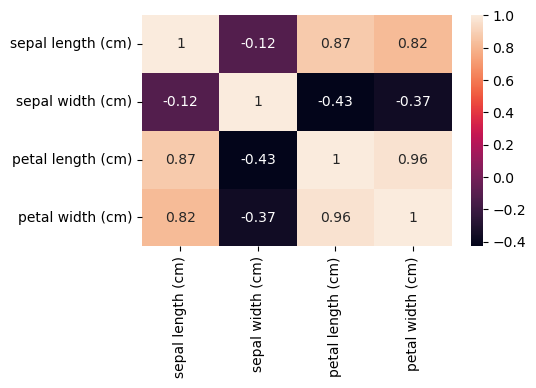

In [4]:
plt.subplots(figsize=(5,3))
sns.heatmap(data=X.corr(), annot=True)
plt.savefig('Heatmap.png',bbox_inches ="tight")

We see here that the 2nd columns is most independent of all the others.  So that is a column that we definitely want to have in our final dataset to feed into our classification algorithm.  

Further, petal length and petal width are highly correlated to each other.  As petal length is also slightly more correlated to sepal length, let's consider removing that variable.  

In [5]:
#X['petal length (cm)']
X_new = X.drop('petal length (cm)', axis=1)

Next let's check the Random Forest accuracy with one column removed: 

In [6]:
print('Performance with one column removed: ')
RandF_quick_analysis(X_new,y)

Performance with one column removed: 
ACCURACY OF THE MODEL:  91.0 %


RandomForestClassifier(random_state=1)

We see a 5% drop in accuracy, however we decreaased the data size by 25% by removing 1 out of 4 varaibles.  You will likely see some performance drop in many cases when you reduce your number of variables.  However, it may be worth it for savings in time and computing resources.  

## Random Forest Variable Importance 
Next, let's examine a different use case.  This comes from a technique called *Differential Power Analysis (DPA)* where each observation is the time sampled Radio Frequency (RF) amplitude response of an 8-bit microcontroller as it is encrypting text with the AES-128 algorithm.  The target is the known Hamming Weight of the byte value that the algorithm is processing at the current time.  For further reading, you can see an introductory presentation here: https://users.fit.cvut.cz/~novotnym/DPA/Analysis/dpa_Lisbon.pdf

For this class, it is sufficient to know that the observations (X) are the RF response samples over time.  So if an observation consists of 1000 variables, then those 1000 variables are the sampled data recorded sequentially in time.  Further, the target (y) is the byte value we are training on, and this results in a 8-class classification use case.  By training on this data, we can build an algorithm that can guess the byte value being processed by the RF response from the chip.   

In [7]:
X = pd.read_csv('DPA_Data.csv', index_col=0)
y = pd.read_csv('DPA_target.csv',index_col=0)

In [8]:
y = np.ravel(y) # flattens the array for use with scipy.  
X.head()

,0,1,2,3,4,5,6,7,8,9,...,24990,24991,24992,24993,24994,24995,24996,24997,24998,24999
0,-104,-107,-107,-84,-71,-59,-41,-58,-46,-52,...,-9,-41,-58,-79,-92,-98,-104,-100,-103,-97
1,-114,-102,-100,-88,-75,-61,-59,-48,-45,-49,...,-7,-46,-58,-74,-82,-93,-102,-91,-100,-90
2,-116,-108,-98,-88,-74,-65,-54,-51,-46,-58,...,-18,-39,-53,-71,-79,-85,-97,-94,-89,-89
3,-112,-115,-93,-85,-81,-66,-53,-53,-39,-51,...,6,-26,-37,-65,-76,-95,-101,-98,-106,-93
4,-109,-110,-100,-87,-81,-68,-57,-51,-47,-51,...,-2,-38,-46,-72,-87,-93,-100,-97,-96,-92


(25000,)


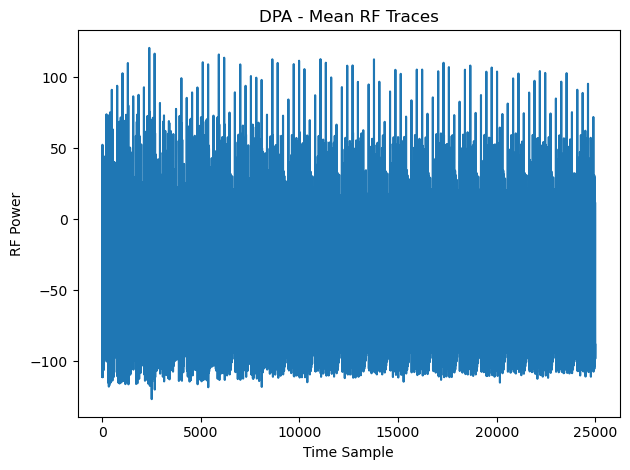

In [9]:
XMean = X.mean(axis=0)
print(XMean.shape)
plt.plot(XMean.values) # faster to use .values (convert to numpy array)
plt.title('DPA - Mean RF Traces')
plt.xlabel('Time Sample')
plt.ylabel('RF Power')
plt.savefig('DPA Average RF Signal.png')
plt.tight_layout()
plt.savefig('DPA_mean')
plt.show()


In [10]:
print('Performance of DPA Data raw: ')
clf = RandF_quick_analysis(X,y)

Performance of DPA Data raw: 
ACCURACY OF THE MODEL:  63.0 %


In [11]:
# Average tree length
max_depth = list()
for tree in clf.estimators_:
    max_depth.append(tree.tree_.max_depth)

print("avg max depth %0.1f" % (sum(max_depth) / len(max_depth)))

avg max depth 14.2


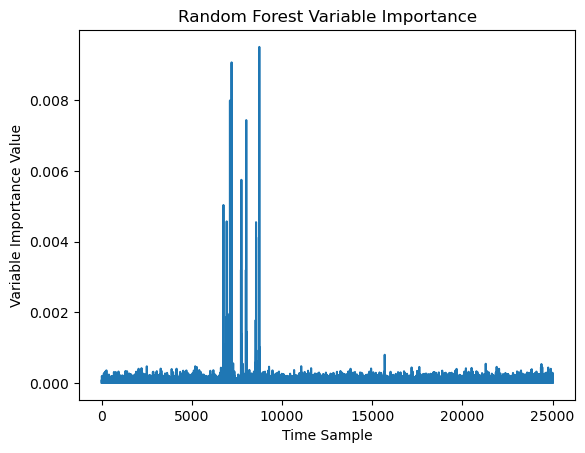

In [12]:
importances = clf.feature_importances_
plt.plot(importances)
plt.title('Random Forest Variable Importance')
plt.xlabel('Time Sample')
plt.ylabel('Variable Importance Value')
plt.savefig('DPA Var Importance.png')
plt.show()

In [13]:
important_ind = importances > 0.001
X_new = X.iloc[:,important_ind]

In [14]:
clf2 = RandF_quick_analysis(X_new,y)

ACCURACY OF THE MODEL:  94.0 %


In [15]:
max_depth = list()
for tree in clf2.estimators_:
    max_depth.append(tree.tree_.max_depth)

print("avg max depth %0.1f" % (sum(max_depth) / len(max_depth)))

avg max depth 12.6


#### Save smaller datasets

In [16]:
#Data_small = pd.DataFrame(X_new.astype(int))
#Data_small.to_csv('DPA_Data_Small.csv')

X_new.to_csv('DPA_Data_Small.csv')

Ydata = pd.DataFrame(y)
Ydata.to_csv('DPA_target.csv')